In [1]:
import sys
sys.path.append("/Users/davidhernandez/Desktop/Nordling_Lab/KD_IG_Code")
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageNet, CIFAR10

from PyTorch_CIFAR10.cifar10_models.mobilenetv2 import mobilenet_v2
from PyTorch_CIFAR10.UTILS_TORCH import *

In [2]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    device = torch.device("mps")

# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(f"Currently using: '{device}'")

Currently using: 'mps'


# ImageNet

### Functions

In [3]:
# Assuming your data is in CIFAR-like format (data is flattened)
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


def parse_class_map(file_path):
    """
    Parses the class map file to get a dictionary mapping ImageNet class ID to the class index.
    """
    class_map = {}
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 2)  # Split by first two spaces
            class_id = parts[0]  # ImageNet ID (e.g., n01440764)
            class_index = int(parts[1])  # Corresponding integer index (e.g., 0)
            class_map[class_id] = class_index
    return class_map

### Class Maps

In [4]:
# Load the class map from map_clsloc.txt
class_map = parse_class_map("../../../ML/PyTorch_CIFAR10/data/map_clsloc.txt")

In [5]:
cifar10_imagenet_classes = {
    # plane
    0: [
        "n02690373",  # airliner
        "n04552348",  # warplane
        "n02692877"   # airship
    ],
    # car
    1: [
        "n04285008",  # sports_car
        "n03895866",  # passenger_car
        "n03444034",  # go_kart
        "n03445924",  # golf_cart
        "n03977966",  # police_van
        "n03770679",  # minivan
        "n03796401",  # moving_van
        "n03930630",  # pickup
        "n03777568",  # model_T
        "n04465501",  # tractor
        "n02930766",  # cab
        "n03100240",  # convertible
        "n03670208",  # limousine
        "n03594945",  # jeep
    ],
    # bird
    2: [
        "n01514668",  # cock
        "n01514859",  # hen
        "n01833805",  # hummingbird
        "n01530575",  # brambling
        "n01531178",  # goldfinch
        "n01532829",  # house_finch
        "n01534433",  # junco
        "n01537544",  # indigo_bunting
        "n01558993",  # robin
        "n01560419",  # bulbul
        "n01580077",  # jay
        "n01582220",  # magpie
        "n01592084",  # chickadee
        "n01601694",  # water_ouzel
        "n01608432",  # kite
        "n01614925",  # bald_eagle
        "n01616318",  # vulture
        "n01622779",  # great_grey_owl
        "n01795545",  # black_grouse
        "n01796340",  # ptarmigan
        "n01797886",  # ruffed_grouse
        "n01798484",  # prairie_chicken
        "n01806143",  # peacock
        "n01806567",  # quail
        "n01807496",  # partridge
        "n01817953",  # African_grey
        "n01818515",  # macaw
        "n01819313",  # sulphur-crested_cockatoo
        "n01820546",  # lorikeet
        "n01824575",  # coucal
        "n01828970",  # bee_eater
        "n01829413",  # hornbill
        "n01843065",  # jacamar
        "n01843383",  # toucan
        "n01847000",  # drake
        "n01855032",  # red-breasted_merganser
        "n01855672",  # goose
        "n01860187",  # black_swan
        "n02002556",  # white_stork
        "n02002724",  # black_stork
        "n02006656",  # spoonbill
        "n02007558",  # flamingo
        "n02009912",  # American_egret
        "n02009229",  # little_blue_heron
        "n02011460",  # bittern
        "n02012849",  # crane
        "n02013706",  # limpkin
        "n02018207",  # American_coot
        "n02018795",  # bustard
        "n02025239",  # ruddy_turnstone
        "n02027492",  # red-backed_sandpiper
        "n02028035",  # redshank
        "n02033041",  # dowitcher
        "n02037110",  # oystercatcher
        "n02017213",  # European_gallinule
        "n02051845",  # pelican
        "n02056570",  # king_penguin
        "n02058221",  # albatross
    ],
    # cat
    3: [
        "n02124075",  # Egyptian_cat
        "n02123394",  # persian_cat
        "n02123159",  # tiger_cat
        "n02123045",  # tabby_cat
        "n02123597",  # Siamese_cat
    ],
    # deer
    4: [],  # No direct deer class in ImageNet

    # dog
    5: [
        "n02110185",  # Siberian_husky
        "n02110063",  # malamute
        "n02091244",  # Ibizan_hound
        "n02091134",  # whippet
        "n02088364",  # beagle
        "n02099712",  # Labrador_retriever
        "n02099429",  # curly-coated_retriever
        "n02097130",  # giant_schnauzer
        "n02097209",  # standard_schnauzer
        "n02098413",  # Lhasa
        "n02098286",  # West_Highland_white_terrier
        "n02096177",  # cairn
        "n02106662",  # German_shepherd
        "n02099601",  # golden_retriever
        "n02095570",  # Lakeland_terrier
    ],
    
    # frog
    6: [
        "n01644900",  # tailed_frog
        "n01641577",  # bullfrog
        "n01644373",  # tree_frog
        # "n01667114",  # mud_turtle
    ],

    # horse
    7: [],  # No direct horse class

    # ship
    8: [
        "n04612504",  # yacht
        "n02687172",  # aircraft_carrier
        "n04147183",  # schooner
        "n03662601",  # lifeboat
        # "n04347754",  # submarine
        "n02951358",  # canoe
    ],

    # truck
    9: [
        "n04467665",  # trailer_truck
        "n03417042",  # garbage_truck
    ]
}


In [6]:
# Handle missing class IDs
missing_class_ids = {}

# Step 2: Map desired class IDs to indices and store them as a dictionary
desired_class_indices = {}

# Iterate over CIFAR-10 categories
for cifar10_class, class_ids in cifar10_imagenet_classes.items():
    class_indices = []
    for class_id in class_ids:
        if class_id in class_map:
            class_indices.append(class_map[class_id])
        else:
            # Log missing class IDs for this CIFAR-10 class
            if cifar10_class not in missing_class_ids:
                missing_class_ids[cifar10_class] = []
            missing_class_ids[cifar10_class].append(class_id)
    
    # Assign the mapped indices to the CIFAR-10 class in the new dictionary
    desired_class_indices[cifar10_class] = class_indices

# Check for missing class IDs and log them
if missing_class_ids:
    print(
        f"Warning: The following class IDs were not found in the class map:\n{missing_class_ids}"
    )
else:
    print("All desired class IDs found in the class map.")

All desired class IDs found in the class map.


In [7]:
desired_class_indices

{0: [230, 231, 232],
 1: [274, 257, 275, 276, 285, 271, 284, 281, 272, 289, 267, 268, 270, 269],
 2: [383,
  384,
  415,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  400,
  401,
  402,
  403,
  404,
  405,
  406,
  407,
  408,
  409,
  410,
  411,
  412,
  413,
  414,
  416,
  417,
  418,
  419,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  427,
  428,
  429,
  430,
  431,
  432,
  433,
  434,
  435,
  436,
  437,
  438,
  439,
  440,
  441],
 3: [8, 10, 55, 174, 95],
 4: [],
 5: [3, 15, 204, 20, 132, 176, 144, 36, 156, 56, 71, 91, 211, 125, 152],
 6: [501, 499, 500],
 7: [],
 8: [240, 246, 221, 238, 239],
 9: [283, 280]}

### Load ImageNet

In [8]:
# Load the unpickled data
imagenet = unpickle("../../../ML/PyTorch_CIFAR10/data/val_data")

# Extract labels and data
labels = imagenet["labels"]
data = imagenet["data"]  # Assuming the data is in a flattened format

In [9]:
len(labels)

50000

51


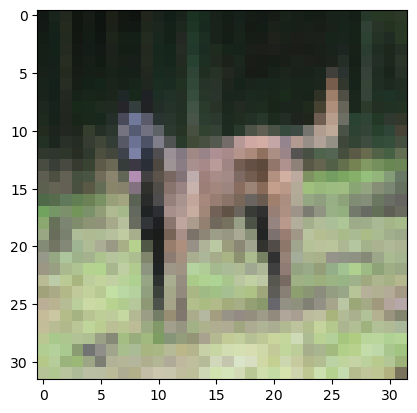

In [10]:
plt.imshow(data[5].reshape(3,32,32).transpose(1,2,0));
print(labels[5])

### Filter based on desired labels

In [11]:
# Filter data based on desired classes
filtered_indices = []

# Iterate through each label in the dataset
for i, label in enumerate(labels):
    # Check if the label matches any class in desired_class_indices
    for cifar10_class, class_indices in desired_class_indices.items():
        if label in class_indices:
            filtered_indices.append(i)
            break  # Exit the inner loop as we've found a match for this label

# Extract the filtered data and labels
filtered_data = data[filtered_indices]
filtered_labels = []

# Map the filtered ImageNet class indices to their corresponding CIFAR-10 labels
for i in filtered_indices:
    for cifar10_class, class_indices in desired_class_indices.items():
        if labels[i] in class_indices:
            filtered_labels.append(cifar10_class)
            break  # Exit the loop once the match is found


In [12]:
len(filtered_labels), np.max(filtered_labels), np.min(filtered_labels)

(5250, 9, 0)

In [13]:
num_samples = {i for i in filtered_labels}

In [14]:
num_samples = {}
for i in filtered_labels:
    num_samples[i] = 0

for i in filtered_labels:
    num_samples[i] +=1

In [15]:
num_samples

{1: 700, 2: 2900, 3: 250, 0: 150, 5: 750, 6: 150, 9: 100, 8: 250}

### Preprocess the Images

In [16]:
# Here, 32x32x3 images are stored as rows in the data matrix
num_images = len(filtered_data)
reshaped_data = filtered_data.reshape(
    num_images, 3, 32, 32
)  # Change the shape to [num_images, 3, 32, 32]

In [17]:
reshaped_data[0].shape

(3, 32, 32)

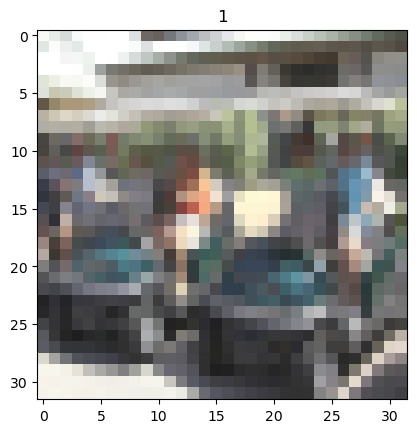

In [18]:
plt.imshow(reshaped_data[0].transpose(1,2,0))
plt.title(filtered_labels[0])
plt.show()

In [19]:
# Define the transforms for the dataset
teacher_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616]
        ),
    ]
)

In [20]:
reshaped_data = reshaped_data.transpose(0, 2, 3, 1)
reshaped_data.shape

(5250, 32, 32, 3)

In [21]:
# Convert to PyTorch tensors
# images_tensor = torch.tensor(reshaped_data, dtype=torch.float32)
images_tensor = torch.stack([teacher_transform(img) for img in reshaped_data])
labels_tensor = torch.tensor(filtered_labels, dtype=torch.long)

In [22]:
images_tensor[0].shape, labels_tensor[0].shape

(torch.Size([3, 32, 32]), torch.Size([]))

In [23]:
images_tensor.max()

tensor(2.1265)

### ImageNet Subset DataLoader

In [24]:
# Optionally, create a dataset and dataloader
dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

### Load Teacher CIFAR10

In [25]:
# load student data
teacher_test_data = CIFAR10(
    root="../../../ML/PyTorch_CIFAR10/data",
    train=False,
    transform=teacher_transform,
)

In [26]:
test_loader = DataLoader(
    teacher_test_data,
    batch_size=64,
    shuffle=False,
    num_workers=10,
    pin_memory=False,
    persistent_workers=True,
)

### Evaluate the teacher model

In [27]:
model = mobilenet_v2(pretrained=True)
model.to(device);

/Users/davidhernandez/Desktop/Nordling_Lab/KD_IG_Code/PyTorch_CIFAR10/cifar10_models/mobilenetv2.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

In [28]:
test_model(model=model, loader=test_loader, device=device)

Accuracy of the model on the Training images: 93.91


In [29]:
test_model(model=model, loader=dataloader, device=device)

Accuracy of the model on the Training images: 67.37142857142857


In [30]:
# Assume you have your original dataset and dataloader as per your snippet
correct_indices = evaluate_and_drop_samples(model=model, loader=dataloader, device=device)

In [31]:
correct = len(correct_indices)
full = len(dataset)
print(correct/full * 100, correct, full)

67.37142857142857 3537 5250


In [32]:
# Filter the dataset to only include correct predictions
filtered_dataset = torch.utils.data.Subset(dataset, correct_indices)

# Create a new DataLoader for the filtered dataset
filtered_dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=64, shuffle=False)

In [33]:
test_model(model=model, loader=filtered_dataloader, device=device)

Accuracy of the model on the Training images: 100.0


In [34]:
metrics = evaluate_model_performance(model=model, dataloader=filtered_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# Print F1-Score report
print("\nF1-Score Report:")
for class_idx, report in metrics["f1_report"].items():
    if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
        print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
print("\nConfusion Matrix:")
print(metrics["confusion_matrix"])

Class-wise Accuracy:
Class 0: 100.00%
Class 1: 100.00%
Class 2: 100.00%
Class 3: 100.00%
Class 4: 0.00%
Class 5: 100.00%
Class 6: 100.00%
Class 7: 0.00%
Class 8: 100.00%
Class 9: 100.00%

F1-Score Report:
Class 0: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 126.0}
Class 1: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 377.0}
Class 2: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2125.0}
Class 3: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 203.0}
Class 5: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 347.0}
Class 6: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 99.0}
Class 8: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 194.0}
Class 9: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 66.0}
Class macro avg: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3537.0}
Class weighted avg: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 353

# Compute IGs on ImageNet

In [42]:
ig_dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=8, shuffle=False)

In [43]:
import captum
from captum.attr import IntegratedGradients

In [ ]:
ig_captum = IntegratedGradients(model)

captum_igs = []  # Store Captum's integrated gradients

# Wrap the DataLoader with tqdm for a progress bar
for inputs, targets in tqdm(ig_dataloader, desc="Computing IGs", leave=True):
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Compute attributions using Captum
    attributions = ig_captum.attribute(
        inputs, target=targets, baselines=inputs * 0, return_convergence_delta=False
    )
    # Sum attributions over the channel dimension and take absolute value
    attributions_summed = torch.sum(torch.abs(attributions), dim=1).cpu().numpy()

    captum_igs.append(attributions_summed)

captum_igs = np.concatenate(captum_igs, axis=0)
np.save('imagenet_igs.npy', captum_igs)
print(f"Shape of IGs array: {captum_igs.shape}")

In [45]:
captum_igs = np.load('imagenet_igs.npy')

In [46]:
def process_ig(ig):
    return np.repeat(np.expand_dims(ig, axis=3), 3, axis=-1)

In [47]:
igs_expanded = process_ig(captum_igs)
igs_expanded.shape

(4900, 32, 32, 3)

In [48]:
igs_norm, _, _ = norm(igs_expanded)

In [49]:
igs_norm.max()

1.0

In [50]:
# Convert to PyTorch tensors
norm_data, _, _ = norm(reshaped_data)
imagenet_tensor = torch.tensor(norm_data, dtype=torch.float32)

# Optionally, create a dataset and dataloader
imagenet_ig = torch.utils.data.TensorDataset(imagenet_tensor, labels_tensor)

In [51]:
img, label = imagenet_ig[4]
img.max()

tensor(0.9882)

In [52]:
image = img.numpy()

In [53]:
overlay_image = 0.5 * igs_norm[4] + 0.5 * image

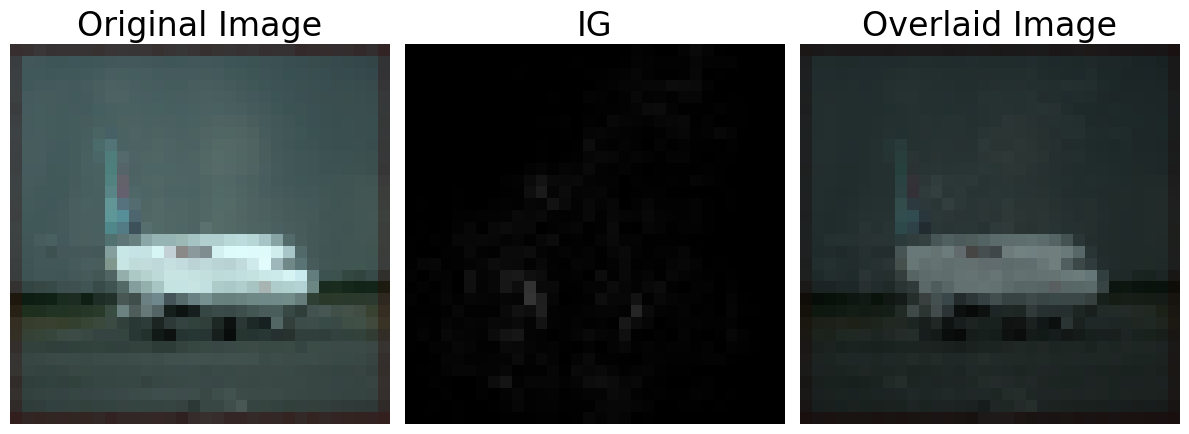

In [54]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image", fontsize=24)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(igs_norm[4])
plt.title("IG", fontsize=24)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlay_image)
plt.title("Overlaid Image", fontsize=24)
plt.axis('off')

plt.tight_layout()
plt.savefig("ImageNet_igs.pdf")
plt.show()

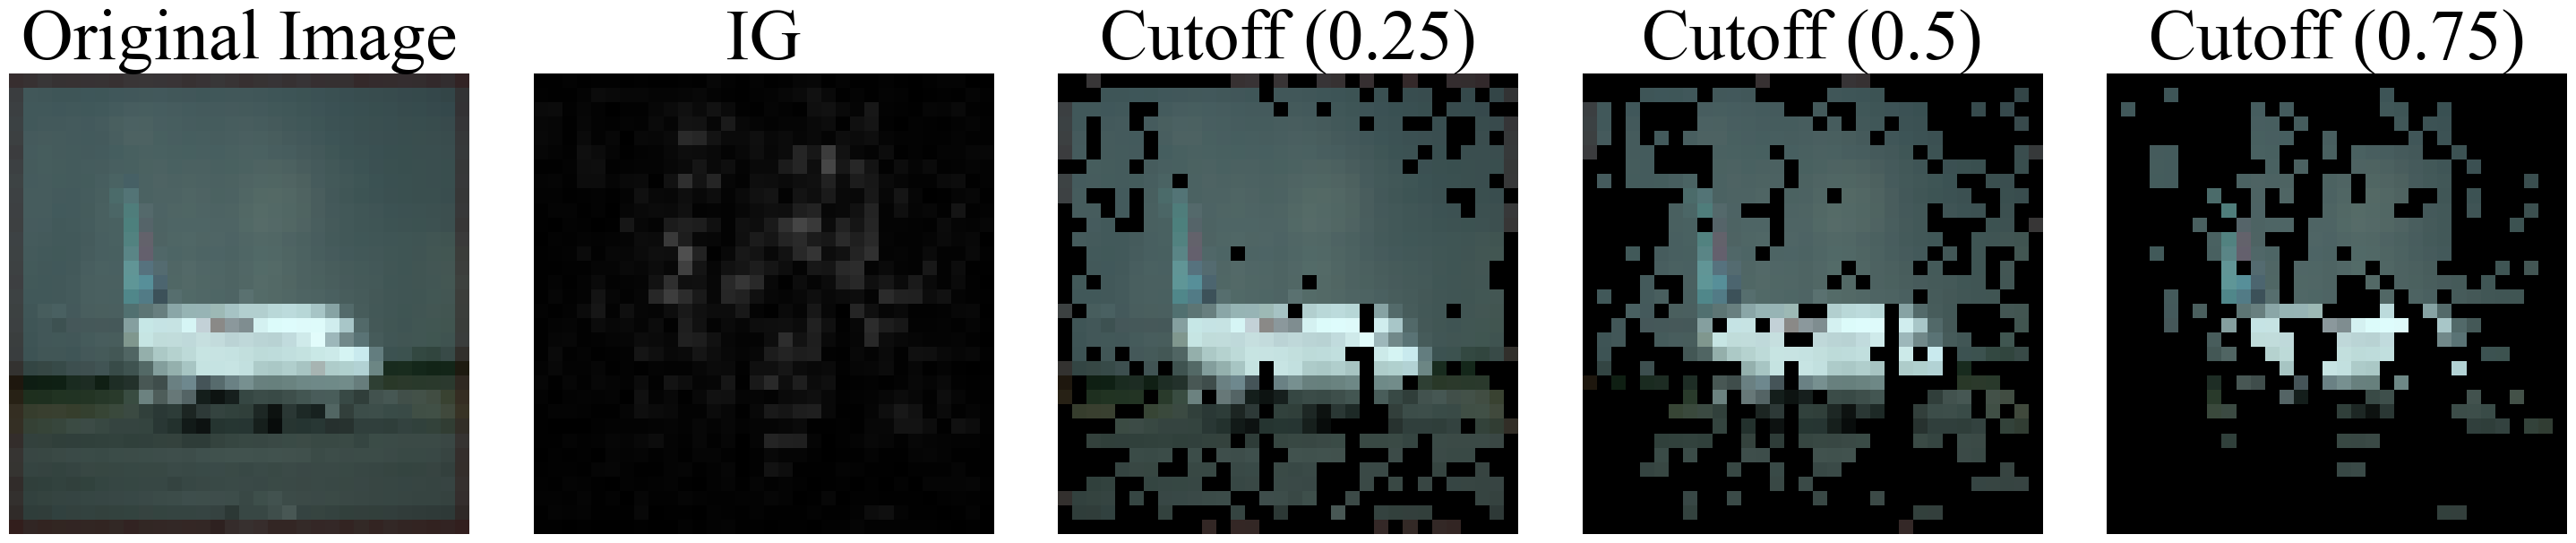

In [82]:
sample = 120

img, label = imagenet_ig[sample]

quantile_values = [np.quantile(igs_norm[sample], q) for q in [0.25, 0.5, 0.75]]
masks_quantile = [(igs_norm[sample] > quantile) for quantile in quantile_values]
masked_images_quantile = [np.where(mask, image, 0) for mask in masks_quantile]

# Plotting with quantile-based cutoffs
fig, ax = plt.subplots(1, 5, figsize=(30, 14))  # 5 subplots
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 48
# Display original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display IG
ax[1].imshow(igs_norm[sample], cmap='gray')
ax[1].set_title('IG')
ax[1].axis('off')

# Display masked images for each quantile threshold
for i, (masked_image, quantile) in enumerate(zip(masked_images_quantile, [0.25, 0.5, 0.75]), start=2):
    ax[i].imshow(masked_image, cmap='gray')
    ax[i].set_title(f'Cutoff ({quantile})')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig("Hernandez2024_ImageNet_igs.pdf")
plt.show()

# Compute the Attention Maps

In [35]:
Teacher_att = ModifiedTeacher(mobilenet_v2(pretrained=True))
Teacher_att.to(device);

/Users/davidhernandez/Desktop/Nordling_Lab/KD_IG_Code/PyTorch_CIFAR10/cifar10_models/mobilenetv2.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

In [36]:
test_model_att(Teacher_att, test_loader, device)

Accuracy of the model on the Testing images: 93.91 %


In [40]:
at_dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=64, shuffle=False)

In [41]:
Teacher_att.eval()

# Initialize a list to hold all attention maps
all_attention_maps = []

# Loop through the dataset
for inputs, _ in at_dataloader:
    inputs = inputs.to(device)
    logits, attention_maps = Teacher_att(inputs)
    
    # Move attention maps to CPU and convert to numpy
    attention_maps_np = attention_maps.detach().cpu().numpy()
    all_attention_maps.append(attention_maps_np)

# Concatenate all attention maps along the first axis (batch axis)
all_attention_maps_np = np.concatenate(all_attention_maps, axis=0)
# Save the complete array of attention maps
np.save("../../../ML/PyTorch_CIFAR10/data/imagenet_attention_maps.npy", all_attention_maps_np)
print(all_attention_maps_np.shape)

(3537, 64)


# Train the student models and evaluate

## Data Loading & Preprocess

### Transforms

In [35]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

student_aug = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

### Imagenet Load 

In [36]:
reshaped_data.shape

(5250, 32, 32, 3)

In [37]:
# Convert to PyTorch tensors
student_images_tensor = torch.stack([transform(img) for img in reshaped_data])

In [38]:
student_images_tensor.min()

tensor(0.)

In [39]:
# Optionally, create a dataset and dataloader
student_dataset = torch.utils.data.TensorDataset(student_images_tensor, labels_tensor)
student_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [40]:
img, _ = student_dataset[0]
img.max()

tensor(1.)

In [41]:
# Filter the dataset to only include correct predictions
filtered_student_dataset = torch.utils.data.Subset(student_dataset, correct_indices)

# Create a new DataLoader for the filtered dataset
filtered_student_dataloader = torch.utils.data.DataLoader(filtered_student_dataset, batch_size=64, shuffle=False)

### hyperparams

In [42]:
# Hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 64
# LEARN_RATE = 0.001
NUM_WORKERS = 10
# ALPHA=0.1
# TEMP=3

### Test Data

In [43]:
# load student data
test_data = CIFAR10(
    root="../../../ML/PyTorch_CIFAR10/data",
    train=False,
    transform=transform,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

### Load Precomputed IG and Logits

In [44]:
IGS = "../../../ML/PyTorch_CIFAR10/data/Captum_IGs.npy"
# Load the precomputed IGs
igs = np.load(IGS)
print(f"IGs shape: {igs.shape}")

IGs shape: (50000, 32, 32)


In [45]:
precomputed_logits = np.load("../../../ML/PyTorch_CIFAR10/data/cifar10_logits.npy")
print("Shape of teacher_logits:", precomputed_logits.shape)

Shape of teacher_logits: (50000, 10)


In [46]:
attn = "../../../ML/PyTorch_CIFAR10/data/cifar10_attention_maps.npy"
# Load the precomputed IGs
att_maps = np.load(attn)
print(f"attention maps shape: {att_maps.shape}")

attention maps shape: (50000, 8, 8)


In [47]:
attn_imagenet = "../../../ML/PyTorch_CIFAR10/data/imagenet_attention_maps.npy"
# Load the precomputed IGs
att_maps_imagenet = np.load(attn_imagenet)
print(f"attention maps shape: {att_maps.shape}")

attention maps shape: (50000, 8, 8)


# KD_IG (overlay_prob=0.1)

## Training

In [48]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="../../../ML/PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    overlay_prob=0.1,
    return_ig=False,
)

In [49]:
# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [50]:
KD_IG = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD_IG.to(device);

## Load model

In [51]:
KD_IG.load_state_dict(torch.load("../../../ML/PyTorch_CIFAR10/Histories/Tuned_KD/KD_IG_0.1/KD_IG_0.1.pt", weights_only=True, map_location=device))

<All keys matched successfully>

## Test on ImageNet

In [52]:
test_model(model=KD_IG, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 17.447619047619046


# KD_IG_AT

In [53]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="../../../ML/PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    precomputed_attn=att_maps,
    overlay_prob=0.1,
    return_ig=False,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=10,
    pin_memory=False,
    persistent_workers=True,
)


In [54]:
KD_IG_AT = ModifiedStudent(mobilenet_v2(pretrained=False))
KD_IG_AT.to(device);

### Load the model

In [55]:
KD_IG_AT.load_state_dict(torch.load("../../../ML/PyTorch_CIFAR10/Histories/AT_param/KD_IG_AT_0.8/KD_IG_AT0.8.pt", weights_only=True, map_location=device))

<All keys matched successfully>

### Test on ImageNet

In [56]:
test_model_att(model=KD_IG_AT, loader=student_dataloader, device=device)

Accuracy of the model on the Testing images: 19.65714285714286 %


# IG (overlay_prob=0.1)

In [57]:
# Define the full training dataset without augmentation for splitting
train_dataset = CIFAR10WithIG(
    igs=igs,
    root="../../../ML/PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
    overlay_prob=0.1,
    return_ig=False,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [58]:
IG = SmallerMobileNet(mobilenet_v2(pretrained=False))
IG.to(device);

### Load the model

In [59]:
IG.load_state_dict(torch.load("../../../ML/PyTorch_CIFAR10/Histories/Tuned_KD/IG_0.1/IG_0.1.pt", weights_only=True, map_location=device))

<All keys matched successfully>

## Test on ImageNet

In [60]:
test_model(model=IG, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 33.714285714285715


# KD

In [61]:
train_dataset = CIFAR10_KD(
    root="../../../ML/PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [62]:
KD = SmallerMobileNet(mobilenet_v2(pretrained=False))
KD.to(device);

### Load the model

In [63]:
KD.load_state_dict(torch.load("/Users/davidhernandez/Desktop/ML/PyTorch_CIFAR10/Histories/Tuned_KD/KD_0.01_2.5/KD_0.01_2.5.pt", weights_only=True, map_location=device))

<All keys matched successfully>

In [64]:
test_model(model=KD, loader=test_loader, device=device)

Accuracy of the model on the Training images: 92.29


## Test on ImageNet

In [65]:
test_model(model=KD, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 34.36190476190476


# Student (baseline)

In [66]:
train_dataset = CIFAR10_KD(
    root="../../../ML/PyTorch_CIFAR10/data",
    train=True,
    transform=student_aug,
    precomputed_logits=precomputed_logits,
)

# Load the data into batches
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=True,
)

In [67]:
student = SmallerMobileNet(mobilenet_v2(pretrained=False))
student.to(device);

In [ ]:
Trained_student, acc_student = train_eval_kd(
    student=student,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=NUM_EPOCHS,
    lr=LEARN_RATE,
    TEMP=1,
    ALPHA=0,
    device=device,
    csv_path="PyTorch_CIFAR10/Histories/Results/Student.csv",
)

In [67]:
print(f"Test Acc = {acc_student:.2f}%")

Test Acc = 91.35%


### Save the model

In [68]:
torch.save(Trained_student.state_dict(), "saved_models/Student.pt")

## Test on Imagenet

In [69]:
test_model(model=Trained_student, loader=student_dataloader, device=device)

Accuracy of the model on the Training images: 19.4


# Evaluate all models on ImageNet

## Teacher

In [68]:
Teacher = mobilenet_v2(pretrained=True)
Teacher.to(device)

acc = test_model(model=Teacher, loader=filtered_dataloader, device=device)

metrics = evaluate_model_performance(model=Teacher, dataloader=filtered_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

/Users/davidhernandez/Desktop/Nordling_Lab/KD_IG_Code/PyTorch_CIFAR10/cifar10_models/mobilenetv2.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

Accuracy of the model on the Training images: 100.0
Class-wise Accuracy:
Class 0: 100.00%
Class 1: 100.00%
Class 2: 100.00%
Class 3: 100.00%
Class 4: 0.00%
Class 5: 100.00%
Class 6: 100.00%
Class 7: 0.00%
Class 8: 100.00%
Class 9: 100.00%

Balanced Accuracy: 1.0000
Cohen's Kappa: 1.0000


In [69]:
acc = test_model(model=KD_IG, loader=filtered_student_dataloader, device=device)

metrics = evaluate_model_performance(model=KD_IG, dataloader=filtered_student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 78.73904438789936
Class-wise Accuracy:
Class 0: 94.44%
Class 1: 75.33%
Class 2: 75.06%
Class 3: 85.71%
Class 4: 0.00%
Class 5: 84.73%
Class 6: 89.90%
Class 7: 0.00%
Class 8: 86.60%
Class 9: 93.94%

Balanced Accuracy: 0.8571
Cohen's Kappa: 0.6941


/Users/davidhernandez/anaconda3/envs/torchm1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [71]:
acc = test_model_att(model=KD_IG_AT, loader=filtered_student_dataloader, device=device)

metrics = evaluate_model_performance(model=KD_IG_AT, dataloader=filtered_student_dataloader, device=device, num_classes=10, attn=True)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Testing images: 78.28668363019509 %
Class-wise Accuracy:
Class 0: 95.24%
Class 1: 77.19%
Class 2: 73.98%
Class 3: 85.22%
Class 4: 0.00%
Class 5: 85.01%
Class 6: 87.88%
Class 7: 0.00%
Class 8: 89.69%
Class 9: 86.36%

Balanced Accuracy: 0.8507
Cohen's Kappa: 0.6884


/Users/davidhernandez/anaconda3/envs/torchm1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [72]:
acc = test_model(model=IG, loader=filtered_student_dataloader, device=device)

metrics = evaluate_model_performance(model=IG, dataloader=filtered_student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 82.32965790217699
Class-wise Accuracy:
Class 0: 97.62%
Class 1: 86.47%
Class 2: 80.38%
Class 3: 83.74%
Class 4: 0.00%
Class 5: 81.84%
Class 6: 80.81%
Class 7: 0.00%
Class 8: 84.54%
Class 9: 86.36%

Balanced Accuracy: 0.8522
Cohen's Kappa: 0.7376


/Users/davidhernandez/anaconda3/envs/torchm1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [73]:
acc = test_model(model=KD, loader=filtered_student_dataloader, device=device)

metrics = evaluate_model_performance(model=KD, dataloader=filtered_student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 81.62284421826406
Class-wise Accuracy:
Class 0: 92.86%
Class 1: 74.80%
Class 2: 80.19%
Class 3: 87.68%
Class 4: 0.00%
Class 5: 86.46%
Class 6: 81.82%
Class 7: 0.00%
Class 8: 85.05%
Class 9: 90.91%

Balanced Accuracy: 0.8497
Cohen's Kappa: 0.7277


/Users/davidhernandez/anaconda3/envs/torchm1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [74]:
Student = SmallerMobileNet(mobilenet_v2(pretrained=False))
Student.to(device)

Student.load_state_dict(torch.load("../saved_models/Student.pt", weights_only=True, map_location=device))

acc = test_model(model=Student, loader=filtered_student_dataloader, device=device)

metrics = evaluate_model_performance(model=Student, dataloader=filtered_student_dataloader, device=device, num_classes=10)
# Print class accuracy
print("Class-wise Accuracy:")
for class_idx, accuracy in metrics["class_accuracy"].items():
    print(f"Class {class_idx}: {accuracy:.2f}%")

# # Print F1-Score report
# print("\nF1-Score Report:")
# for class_idx, report in metrics["f1_report"].items():
#     if isinstance(report, dict):  # Ensure we're only printing relevant class-wise details
#         print(f"Class {class_idx}: {report}")

# Print other metrics
print(f"\nBalanced Accuracy: {metrics['balanced_accuracy']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
# print("\nConfusion Matrix:")
# print(metrics["confusion_matrix"])

Accuracy of the model on the Training images: 80.88775798699463
Class-wise Accuracy:
Class 0: 96.03%
Class 1: 72.94%
Class 2: 80.75%
Class 3: 82.27%
Class 4: 0.00%
Class 5: 78.96%
Class 6: 84.85%
Class 7: 0.00%
Class 8: 85.05%
Class 9: 89.39%

Balanced Accuracy: 0.8378
Cohen's Kappa: 0.7155


/Users/davidhernandez/anaconda3/envs/torchm1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# ImageNet Evaluation Plot

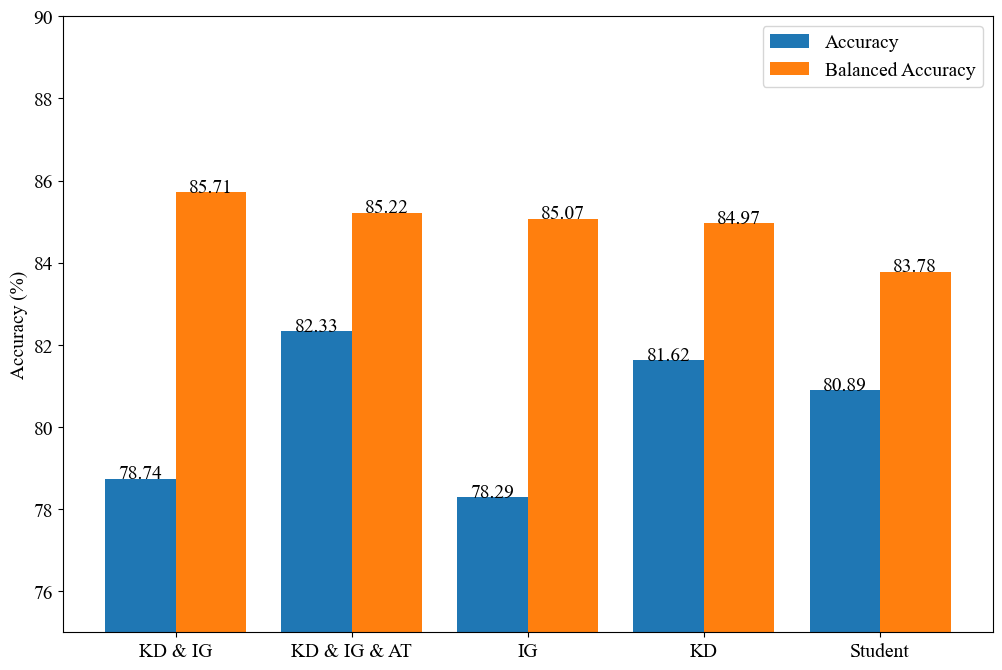

In [76]:
plt.figure(figsize=(12,8))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
methods = ['KD & IG', "KD & IG & AT", "IG", 'KD', 'Student']
method = np.arange(len(methods))
imagenet_acc = [78.74, 82.33, 78.29, 81.62, 80.89]
balanced_acc = [85.71, 85.22, 85.07, 84.97, 83.78]
plt.bar(method - 0.2, imagenet_acc, 0.4, label = 'Accuracy')
plt.bar(method + 0.2, balanced_acc, 0.4, label = 'Balanced Accuracy')
# plt.axhline(100, color='red', label='Teacher', linestyle='dashed')
plt.legend()
plt.xticks(method, methods, rotation=0)
plt.ylabel("Accuracy (%)")
plt.ylim(75, 90)
for i in range(len(method)):
    plt.text(i - 0.2, imagenet_acc[i], imagenet_acc[i], ha = 'center')
    plt.text(i + 0.2, balanced_acc[i], balanced_acc[i], ha = 'center')
plt.savefig("Hernandez2024_ImageNet_evaluation.pdf")
plt.show()